<a href="https://colab.research.google.com/github/shahabday/graph-neural-networks/blob/main/Copy_of_0_EquivariantGNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# PLEASE, MAKE A COPY OF THIS COLAB BEFORE RUNNING ANYTHING.

import torch
import os
# Install required packages.
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-cluster -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install -q py3Dmol
!pip install -q rdkit-pypi
!pip install -q e3nn

2.5.1+cu124
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 90.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 48.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.7/447.7 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 75.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 63.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8

In [ ]:
import gdown
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import plotly.graph_objects as go
import random
import seaborn as sns
import time
import torch
import torch_geometric.transforms as T


from e3nn import o3
from e3nn.o3 import Irreps
from plotly.subplots import make_subplots
from scipy.stats import ortho_group
from torch_geometric.data import Data, InMemoryDataset, download_url, extract_zip
from torch_geometric.data import Batch
from torch_geometric.datasets import QM9
from torch_geometric.utils import remove_self_loops, to_dense_adj, dense_to_sparse
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MessagePassing, global_mean_pool, MLP
from torch_geometric.transforms import BaseTransform
from torch_scatter import scatter

import rdkit.Chem as Chem
from rdkit.Geometry.rdGeometry import Point3D
from rdkit.Chem import QED, Crippen, rdMolDescriptors, rdmolops
from rdkit.Chem.Draw import IPythonConsole

# Packages for plotting molecules
import py3Dmol
from rdkit.Chem import AllChem


from IPython.display import HTML

In [ ]:
# A helper function to set a random seed
def seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed(12345)

In [ ]:
# Some useful transforms
class SetTarget(BaseTransform):
    """
    This transform modifies the labels vector per data sample to only keep
    the label for a specific target (there are 19 targets in QM9).
    """
    def __call__(self, data):
        # A hardcoded choice of target (EDM)
        target = 0
        data.y = data.y[:, target]
        return data


class CompleteGraph(BaseTransform):
    """
    This transform adds all pairwise edges into the edge index per data sample,
    then removes self loops, i.e. it builds a fully connected or complete graph
    """
    def __call__(self, data):
        device = data.edge_index.device

        row = torch.arange(data.num_nodes, dtype=torch.long, device=device)
        col = torch.arange(data.num_nodes, dtype=torch.long, device=device)

        row = row.view(-1, 1).repeat(1, data.num_nodes).view(-1)
        col = col.repeat(data.num_nodes)
        edge_index = torch.stack([row, col], dim=0)

        edge_attr = None
        if data.edge_attr is not None:
            idx = data.edge_index[0] * data.num_nodes + data.edge_index[1]
            size = list(data.edge_attr.size())
            size[0] = data.num_nodes * data.num_nodes
            edge_attr = data.edge_attr.new_zeros(size)
            edge_attr[idx] = data.edge_attr

        edge_index, edge_attr = remove_self_loops(edge_index, edge_attr)
        data.edge_attr = edge_attr
        data.edge_index = edge_index

        return data

There are a lot of helper functions for visualization of molecules and some geometric properties given below. You don't need to understand the code, it's sufficient to just use them.

In [ ]:
# Helper function to plotting molecules with rdkit package
allowable_atoms = [
    "H",
    "C",
    "N",
    "O",
    "F",
    "C",
    "Cl",
    "Br",
    "I",
    "H",
    "Unknown",
]

def to_atom(t):
    try:
        return allowable_atoms[int(t.argmax())]
    except:
        return "C"


def to_bond_index(t):
    t_s = t.squeeze()
    return [1, 2, 3, 4][
        int(
            torch.dot(
                t_s,
                torch.tensor(
                    range(t_s.size()[0]), dtype=torch.float, device=t.device
                ),
            ).item()
        )
    ]

def to_rdkit(data, device=None):
    has_pos = False
    node_list = []
    for i in range(data.x.size()[0]):
        node_list.append(to_atom(data.x[i][:5]))

    # create empty editable mol object
    mol = Chem.RWMol()
    # add atoms to mol and keep track of index
    node_to_idx = {}
    invalid_idx = set([])
    for i in range(len(node_list)):
        if node_list[i] == "Stop" or node_list[i] == "H":
            invalid_idx.add(i)
            continue
        a = Chem.Atom(node_list[i])
        molIdx = mol.AddAtom(a)
        node_to_idx[i] = molIdx

    added_bonds = set([])
    for i in range(0, data.edge_index.size()[1]):
        ix = data.edge_index[0][i].item()
        iy = data.edge_index[1][i].item()
        bond = to_bond_index(data.edge_attr[i])  # <font color='red'>TODO</font> fix this
        # bond = 1
        # add bonds between adjacent atoms

        if data.edge_attr[i].sum() == 0:
          continue

        if (
            (str((ix, iy)) in added_bonds)
            or (str((iy, ix)) in added_bonds)
            or (iy in invalid_idx or ix in invalid_idx)
        ):
            continue
        # add relevant bond type (there are many more of these)

        if bond == 0:
            continue
        elif bond == 1:
            bond_type = Chem.rdchem.BondType.SINGLE
            mol.AddBond(node_to_idx[ix], node_to_idx[iy], bond_type)
        elif bond == 2:
            bond_type = Chem.rdchem.BondType.DOUBLE
            mol.AddBond(node_to_idx[ix], node_to_idx[iy], bond_type)
        elif bond == 3:
            bond_type = Chem.rdchem.BondType.TRIPLE
            mol.AddBond(node_to_idx[ix], node_to_idx[iy], bond_type)
        elif bond == 4:
            bond_type = Chem.rdchem.BondType.SINGLE
            mol.AddBond(node_to_idx[ix], node_to_idx[iy], bond_type)

        added_bonds.add(str((ix, iy)))

    if has_pos:
        conf = Chem.Conformer(mol.GetNumAtoms())
        for i in range(data.pos.size(0)):
            if i in invalid_idx:
                continue
            p = Point3D(
                data.pos[i][0].item(),
                data.pos[i][1].item(),
                data.pos[i][2].item(),
            )
            conf.SetAtomPosition(node_to_idx[i], p)
        conf.SetId(0)
        mol.AddConformer(conf)

    # Convert RWMol to Mol object
    mol = mol.GetMol()
    mol_frags = rdmolops.GetMolFrags(mol, asMols=True, sanitizeFrags=False)
    largest_mol = max(mol_frags, default=mol, key=lambda m: m.GetNumAtoms())
    return largest_mol



def MolTo3DView(mol, size=(300, 300), style="stick", surface=False, opacity=0.5):
    """Draw molecule in 3D

    Args:
    ----
        mol: rdMol, molecule to show
        size: tuple(int, int), canvas size
        style: str, type of drawing molecule
               style can be 'line', 'stick', 'sphere', 'carton'
        surface, bool, display SAS
        opacity, float, opacity of surface, range 0.0-1.0
    Return:
    ----
        viewer: py3Dmol.view, a class for constructing embedded 3Dmol.js views in ipython notebooks.
    """
    assert style in ('line', 'stick', 'sphere', 'carton')

    mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol)
    AllChem.MMFFOptimizeMolecule(mol, maxIters=200)
    mblock = Chem.MolToMolBlock(mol)
    viewer = py3Dmol.view(width=size[0], height=size[1])
    viewer.addModel(mblock, 'mol')
    viewer.setStyle({style:{}})
    if surface:
        viewer.addSurface(py3Dmol.SAS, {'opacity': opacity})
    viewer.zoomTo()
    return viewer

def smi2conf(smiles):
    '''Convert SMILES to rdkit.Mol with 3D coordinates'''
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        mol = Chem.AddHs(mol)
        AllChem.EmbedMolecule(mol)
        AllChem.MMFFOptimizeMolecule(mol, maxIters=200)
        return mol
    else:
        return None


# Spherical harmonics visualization helpers
axis = dict(
    showbackground=False,
    showticklabels=False,
    showgrid=False,
    zeroline=False,
    title='',
)

layout = dict(
    showlegend=False,
    scene=dict(
        aspectmode="data",
        xaxis=dict(
            **axis,
        ),
        yaxis=dict(
            **axis,
        ),
        zaxis=dict(
            **axis,
        ),
    ),
    paper_bgcolor="rgba(0,0,0,0)",
    plot_bgcolor="rgba(0,0,0,0)",
    margin=dict(l=0, r=0, t=0, b=0)
)

def s2_grid(N=100):
    """ Create grid on which we can sample spherical signals """
    betas = torch.linspace(0, math.pi, int(N/2))
    alphas = torch.linspace(0, 2 * math.pi, N)
    beta, alpha = torch.meshgrid(betas, alphas)
    return o3.angles_to_xyz(alpha, beta)

def sh_trace(sh, cmin, cmax, grid, warp=True, pos=None):

    if warp:
        grid = grid*sh.abs().unsqueeze(-1)

    if pos is not None:
        grid = grid + pos

    # Plot nodes
    x = grid[..., 0]
    y = grid[..., 1]
    z = grid[..., 2]
    trace = go.Surface(x=x, y=y, z=z, surfacecolor=sh, colorscale='RdBu_r', cmin=cmin, cmax=cmax)
    return trace

def plot_all_shs(lmax, grid=s2_grid(), warp=True):
    fig = go.Figure(layout=layout)

    irreps = Irreps.spherical_harmonics(lmax)
    shs = o3.spherical_harmonics(irreps, grid, True)

    cmin = shs.min().item()
    cmax = shs.max().item()

    for l in range(irreps.lmax+1):
        for m in range(-l, l+1):
            i = 2*l + m
            pos = torch.tensor([0, 2*m, -2*l])
            trace = sh_trace(shs[..., i], cmin, cmax, grid=grid, warp=warp, pos=pos)
            fig.add_trace(trace)

    fig.show()

def sphere_trace(coefficients, l_max, grid=s2_grid(), warp=True):
    irreps = Irreps.spherical_harmonics(l_max)
    shs = o3.spherical_harmonics(irreps, grid, True)

    shs *= coefficients.view(1, 1, -1)
    shs = shs.sum(-1)

    cmin = shs.min().item()
    cmax = shs.max().item()

    trace = sh_trace(shs, cmin, cmax, grid=grid, warp=warp)
    return trace

def plot_sphere(coefficients, l_max, grid=s2_grid(), warp=True):
    fig = go.Figure(layout=layout)

    trace = sphere_trace(coefficients, l_max, grid=grid, warp=warp)
    fig.add_trace(trace)
    fig.show()

def plot_dirac(degrees, grid, warp=False):
    fig = make_subplots(
        rows=1, cols=len(degrees), specs=[[{'is_3d': True} for _ in degrees]],
        shared_xaxes=True, shared_yaxes=True,
    )

    for i, l in enumerate(degrees, start=1):
        shs = o3.spherical_harmonics(Irreps.spherical_harmonics(l), grid, True)
        c = shs[10, 20] * np.sin(np.pi / 10)
        fig.add_trace(sphere_trace(c, l, grid, warp=warp), 1, i)

    fig.update_layout(layout)
    fig.update_scenes(xaxis_visible=False, yaxis_visible=False, zaxis_visible=False)
    fig.update_traces(showscale=False)
    fig.show()

/usr/local/lib/python3.11/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
# Dictionary and a dataframe for storing experimental results
RESULTS = {}
DF_RESULTS = pd.DataFrame(columns=["Test MAE", "Val MAE", "Epoch", "Model"])

### Resources:

- [E(n) Equivariant Graph Neural Networks](https://arxiv.org/abs/2102.09844)
- [Tensor Field Networks](https://arxiv.org/abs/1802.08219)
- [On the Expressive Power of Geometric Graph Neural Networks](https://arxiv.org/abs/2301.09308)
- [SMILES representation](https://de.wikipedia.org/wiki/Simplified_Molecular_Input_Line_Entry_System)


#### Sources:

A large part of the notebook material was taken from:

1. [Cambridge GDL practical](https://github.com/chaitjo/geometric-gnn-dojo)
2. [Amsterdam University tutorial on equivariant GNNs](https://colab.research.google.com/drive/1gJhyeQiK7dh2xN6gwVkpIhiTkBVwO9YV?usp=sharing#scrollTo=M0_8Su5JC5yp)

**NOTE:** *The solutions for the Cambridge GDL practical given here are not unique and represent just one possible way to implement it.*

# Geometric Deep Learning on Graphs

This colab will walk us through the main principles of building graph neural networks that heavily utilize geometric information and obey certain principles of invariance and equivariance with respect to some transformations. These models are typically used in physics, chemistry, 3D computer vision, computational biology, but one could also use them for a wider range of problems where geometric information is valuable.

<div align="center">
    <img src="https://drive.google.com/uc?export=view&id=1bE5mfpUTs30_6UrpXtvI-knY0YtQmSsK" width="500" height="500"/>
    <br>
</div>

## Real world application

1. The most prominent example of application of equivariant GNNs is the model from DeepMind - AlphaFold2.

- [AlphaFold2](https://www.nature.com/articles/s41586-021-03819-2) first saw the world in 2020.  
- It has solved a 50-year-old challenge of protein folding.
- Given an input sequence of amino acids that comprise a protein, AlphaFold 2 generates their joint 3D structure.
-  AlphaFold system achieves a median score of 92.4 GDT (percentage of amino acid residues within a threshold distance from the correct position) A score of 90 GDT is considered to be competitive with results obtained from experimental methods.

<div align="center">
    <img src="https://drive.google.com/uc?export=view&id=1Syo7bHEGi1dz84conwfAW4R2pHiV_W-Y"
    <br>
</div>

<div align="center">
    <img src="https://drive.google.com/uc?export=view&id=1-4AVhH277cWKroCIGk_PeiH3nO6X0n2-"
    <br>
</div>

**NOTE:** *AlphaFold 3 ditched equivariance, since the results were better without it and the reasons are yet to be understood. (Perhaps, the diffusion used in it implicitly models equivariance).*


2. Another famous example of GNNs being used in molecular property prediction is in the world of antibiotic discovery.

- A GNN trained to predict how much a molecule would inhibit a bacteria was able to identify the previously overlooked compound [**Halicin**](https://news.mit.edu/2020/artificial-intelligence-identifies-new-antibiotic-0220) during virtual screening.
- Halicin showed powerful results during *in vitro* (in cell) testing.
- It has a completely novel mechanism of action that no bacteria has developed resistance to (yet).

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/3a/Halicin.svg/440px-Halicin.svg.png" width="50%">


## Molecular Property Prediction (Recap)

Let's return to the molecular property prediction task one more time to study in detail the notions of invariance and equivariance in GNNs.

Molecules are a great example of an object from nature that can easily be represented as a graph of atoms (nodes) connected by bonds (edges). Once a GNN is trained, the model's predictions can then be used to guide the drug design process.

<img src="https://drive.google.com/uc?id=1C1tA-DwFhkEKP1I6gizhIZOxQBhooz8D" align="center">


## The QM9 Dataset

QM9 (Quantum Mechanics dataset 9) is a dataset consisting of about **130,000 small molecules** with 19 regression targets. Since being used by [MoleculeNet](https://arxiv.org/abs/1703.00564), it has become a popular dataset to benchmark new architectures for molecular property prediction.

Specifically, we will be predicting the [electric dipole moment](https://en.wikipedia.org/wiki/Electric_dipole_moment) of drug-like molecules. According to Wikipedia:
> "The electric dipole moment is a measure of the separation of positive and negative electrical charges within a system, that is, a measure of the system's overall polarity."

We can visualize this concept via the water molecule H<sub>2</sub>0, which forms a dipole due to its slightly different distribution of negative (red) and postive (blue) charge.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/1/15/Water-elpot-transparent-3D-balls.png/500px-Water-elpot-transparent-3D-balls.png" width="35%">

You do not need to worry about the physical and chemical principles that underpin dipole moments!

- Writing the equations from first priciples to predict a property like this, espeically for complex molecules (e.g. proteins), is very difficult.
- However, these molecules can be represented as graphs with node and edge features as well as **spatial information** that we can use to train a GNN model using the ground truth labels.

Let's load the QM9 dataset and explore how molecular graphs are represented.

In [1]:
def download_data(file_id: str, file_name: str, destination_dir: str="qm9") -> None:
    url = f'https://drive.google.com/uc?id={file_id}'
    destination_dir = os.path.join(destination_dir, "raw")
    if not os.path.exists(destination_dir):
        os.makedirs(destination_dir)
    destination_path = os.path.join(destination_dir, file_name)
    gdown.download(url, destination_path, quiet=True)

file_id_name = ("1uAsmRl0P40a8W8CN2s7ig3Xo7Z9QQ2Tk", "uncharacterized.txt")

# Download the file needed for the preprocessing of the dataset
download_data(*file_id_name)

NameError: name 'os' is not defined

In [ ]:
class QM9FixDownload(QM9):
    def download(self) -> None:
        try:
            import rdkit
            file_path = download_url(self.raw_url, self.raw_dir)
            extract_zip(file_path, self.raw_dir)
            os.unlink(file_path)

        except ImportError:
            path = download_url(self.processed_url, self.raw_dir)
            extract_zip(path, self.raw_dir)
            os.unlink(path)

In [ ]:
path = './qm9'
target = 0

# Transforms which are applied during data loading:
# (1) Fully connect the graphs, (2) Select the target/label
transform = T.Compose([CompleteGraph(), SetTarget()])

# Load the QM9 dataset with the transforms defined
dataset = QM9FixDownload(path, pre_transform=transform)

# Normalize targets per data sample to mean = 0 and std = 1.
mean = dataset.data.y.mean(dim=0, keepdim=True)
std = dataset.data.y.std(dim=0, keepdim=True)
dataset.data.y = (dataset.data.y - mean) / std
mean, std = mean.item(), std.item()

Extracting qm9/raw/qm9.zip
Processing...
100%|██████████| 133885/133885 [03:09<00:00, 707.49it/s]
Done!
/usr/local/lib/python3.11/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


## Data Preparation and Splitting

The QM9 dataset has over **130,000** molecular graphs!

- We will work with a small subset of **3000** molecular graphs.
- Then we will use 1000 graphs for training, validation, and testing.


In [ ]:
seed(12345)

print(f"Total number of samples: {len(dataset)}.")
# Split datasets (our 3K subset)
train_dataset = dataset[:1000]
val_dataset = dataset[1000:2000]
test_dataset = dataset[2000:3000]
print(f"Created dataset splits with {len(train_dataset)} training, {len(val_dataset)} validation, {len(test_dataset)} test samples.")

# Create dataloaders with batch size = 32
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Total number of samples: 130831.
Created dataset splits with 1000 training, 1000 validation, 1000 test samples.


## Visualising Molecular Graphs

To get a better understanding of how the QM9 molecular graphs look like, let's visualise a few samples from the training set along with their corresponding target (their dipole moment).

- In the following plot sparse graphs are visualized, the edges represent physical connections (i.e. bonds).
- We will use **fully-connected graphs** and encode the graph structure in the attributes of each node.


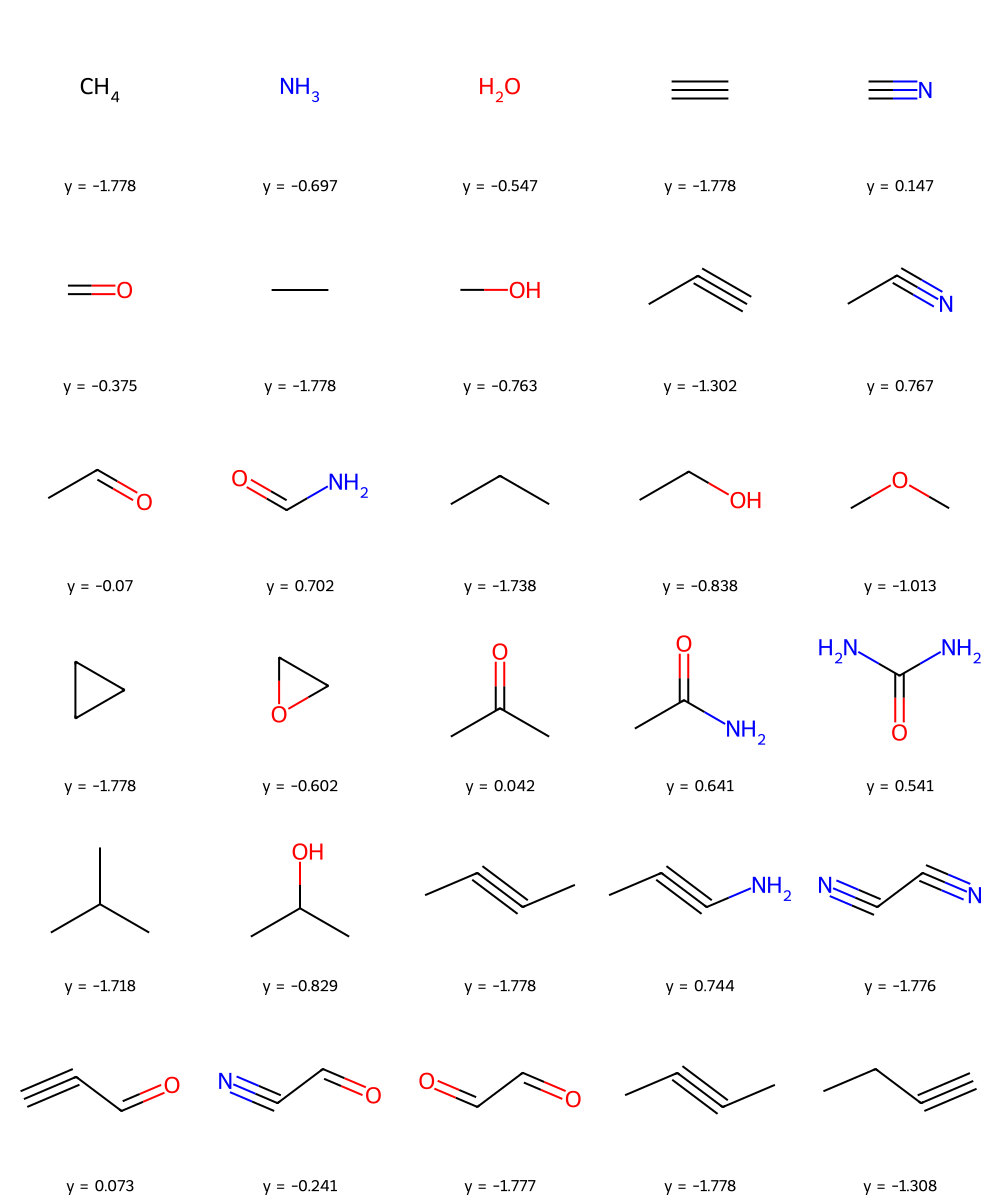

In [ ]:
num_viz = 30
mols = [to_rdkit(train_dataset[i]) for i in range(num_viz)]
values = [str(round(float(train_dataset[i].y), 3)) for i in range(num_viz)]

Chem.Draw.MolsToGridImage(mols, legends=[f"y = {value}" for value in values], molsPerRow=5)

## Dataset understanding

Each graph in the dataset is a molecule.

In [ ]:
data = train_dataset[2]
print(data)

Data(x=[3, 11], edge_index=[2, 6], edge_attr=[6, 4], y=[1], pos=[3, 3], z=[3], smiles='[H]O[H]', name='gdb_3', idx=[1])


In [ ]:
data.edge_index

tensor([[0, 0, 1, 1, 2, 2],
        [1, 2, 0, 2, 0, 1]])

In [ ]:
data.x

tensor([[0., 0., 0., 1., 0., 8., 0., 0., 0., 0., 2.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

The graphs come with a number of pre-computed features which are described below (do not worry if you are unfamiliar with the chemistry terms here):

**Atom features (`data.x`)** - $\mathbb{R}^{|V| \times 11}$
- 1st-5th features: Atom type (one-hot: H, C, N, O, F).
- 6th feature (also `data.z`): [Atomic number](https://en.wikipedia.org/wiki/Atomic_number) (number of protons).
- 7th feature: [Aromaticity](https://en.wikipedia.org/wiki/Aromaticity) (binary).
- 8th-10th features: [Electron orbital hybridization](https://en.wikipedia.org/wiki/Orbital_hybridisation) (one-hot: sp, sp2, sp3).
- 11th feature: Number of [hydrogen](https://en.wikipedia.org/wiki/Hydrogen) atoms an atom connected to.

**Edge Index (`data.edge_index`)** - $\mathbb{R}^{2×|E|}$
- A tensor of dimensions 2 x `num_edges` that describes the edge connectivity of the graph.

**Edge features (`data.edge_attr`)** - $\mathbb{R}^{|E|\times 4}$
- 1st-4th features: atomic bond type (one-hot: single, double, triple, aromatic).

**Atom positions (`data.pos`)** - $\mathbb{R}^{|V|\times 3}$
- 3D coordinates of each atom.

**Target (`data.y`)** - $\mathbb{R}^{1}$
- A scalar value corresponding to the molecule's electric dipole moment.

**Note:** We will be using **fully-connected graphs** (i.e. all atoms in a molecule are connected to each other, except self-loops). The information about the molecule structures will be available to the models through the edge features (`data.edge_attr`) as follows:
- When two atoms are physically connected, the edge attributes indicate the **bond type** (single, double, triple, or aromatic) through a one-hot vector.
- When two atoms are not physically connected, **all edge attributes** are **zero**.



In [ ]:
mol_stats= (f"--- {data.x.shape[0]} atoms\n"
    f"--- {data.edge_attr.shape[0]} edges\n"
    f"--- {data.x.shape[1]}-dimensional node feature for each atom\n"
    f"--- {data.pos.shape[1]}-dimensional coordinates for each atom\n"
    f"--- {data.edge_attr.shape[1]}-dimensional edge feature vector for each edge\n"
    f"--- {data.y.shape[0]} regression target that corresponds to the electric dipole moment"
)

print(f"This molecule has: \n{mol_stats}")

This molecule has: 
--- 3 atoms
--- 6 edges
--- 11-dimensional node feature for each atom
--- 3-dimensional coordinates for each atom
--- 4-dimensional edge feature vector for each edge
--- 1 regression target that corresponds to the electric dipole moment


## MPNN recap

As a baseline, we will use a simplified version of the MPNN model that we have implemented on day 1 of this course. The message passing mechanism is shown in the picture below:

<img src="https://drive.google.com/uc?id=1s3InnS0-nGTzuzGOjiHNTtUGE0NB78g7" width="500" align="center">

### Layer update

Let's break down the MPNN layer into three steps:
- **Step (1): Message.** For each pair of linked nodes $i, j$, the network first computes a message $m_{ij} =  \psi \left( h_i^{\ell}, h_j^{\ell}, e_{ij} \right)$. The MLP $\psi: \mathbb{R}^{2d + d_e} → \mathbb{R}^d$ takes as input the concatenation of the feature vectors from the source node, destination node and the edge.
- **Step (2): Aggregate.** At each node $i$, the incoming messages from all its neighbors are then aggregated as $m_{i} = \oplus_{{j \in \mathcal{N}_i}} \left( m_{ij} \right)$, where $\oplus$ is a permutation-invariant function (we will use summation).
- **Step (3): Update.** Finally, the network updates the node feature vector $h_i^{\ell+1} = \phi \left( h_i^{\ell}, m_i \right)$, by concatenating the aggregated message $m_i$ and the previous node feature vector $h_i^{\ell}$, and passing them through an MLP $\phi: \mathbb{R}^{2d} → \mathbb{R}^{d}$.

**Note:** we do not have any global attribute here and we do not update edge features!

### Global Pooling and Prediction Head
After $L$ layers of message passing, we obtain the final node features $h_i^{\ell=L}$, which we need to pool over to get a graph embedding and the final prediction. It will be global average pooling over all node features:
$$
h_G = \frac{1}{|\mathcal{V}|} \sum_{i \in \mathcal{V}} h_i^{\ell=L}.
$$

This graph embedding $h_G$ is passed through a linear prediction head $W_{pred} \in \mathbb{R}^{d} \rightarrow \mathbb{R}^1$ to obtain the overall prediction $\hat y \in \mathbb{R}^1$:
$$
\hat y = W_{pred} \left( h_G \right).
$$

### Loss Function
Our MPNN graph property prediction model can be trained end-to-end via minimizing the standard mean-squared error loss for regression:
$$
\mathcal{L}_{MSE} = \lVert y - \hat y \rVert^2_2.
$$

### Implementation via `MessagePassing` class of PyG

Let's implement this MPNN layer together

In [ ]:
class MPNNLayer(MessagePassing):
    def __init__(self, emb_dim=64, edge_dim=4, aggr='add'):
        """Message Passing Neural Network Layer

        Args:
            emb_dim: (int) - hidden dimension `d`
            edge_dim: (int) - edge feature dimension `d_e`
            aggr: (str) - aggregation function (sum/mean/sum)
        """
        pass
        # +++++ WRITE TOGETHER +++++

    def forward(self, h, edge_index, edge_attr):
        """
        The forward pass updates node features `h` via one round of message passing.
        The MessagePassing parent class handles most of the logic for the implementation.
        To build custom GNNs, we only need to define our own `message()`,
        `aggregate()`, and `update()` functions (defined subsequently).

        Args:
            h: (n, d) - initial node features
            edge_index: (e, 2) - pairs of edges (i, j)
            edge_attr: (e, d_e) - edge features

        Returns:
            out: (n, d) - updated node features
        """
        pass
        # +++++ WRITE TOGETHER +++++

    def message(self, h_i, h_j, edge_attr):
        """Step (1) Message

        The `message()` function constructs messages from source nodes j
        to destination nodes i for each edge (i, j) in `edge_index`.

        Tensors passed to method `propagate` can be mapped to the respective nodes `i` and `j`
        by appending `_i` or `_j` to the variable name, .e.g. pos_i and pos_j.

        The `message()` function constructs messages for each edge in the graph.
        The indexing of the original node features `h` (or other node variables) is handled under
        the hood by PyG.

        Args:
            h_i: (e, d) - destination node features
            h_j: (e, d) - source node features
            edge_attr: (e, d_e) - edge features

        Returns:
            msg: (e, d) - messages `m_ij` passed through MLP `\psi`
        """
        pass
        # +++++ WRITE TOGETHER +++++


    def aggregate(self, inputs, index):
        """Step (2) Aggregate

        The `aggregate` function aggregates the messages from neighboring nodes,
        according to the chosen aggregation function.

        Args:
            inputs: (e, d) - messages `m_ij` from destination to source nodes
            index: (e, 1) - list of source nodes for each edge/message in `input`

        Returns:
            aggr_out: (n, d) - aggregated messages `m_i`
        """
        return scatter(inputs, index, dim=self.node_dim, reduce=self.aggr)

    def update(self, aggr_out, h):
        """
        Step (3) Update

        The `update()` function computes the final node features by combining the
        aggregated messages with the initial node features.

        `update()` takes the first argument `aggr_out`, the result of `aggregate()`,
        as well as any optional arguments that were initially passed to
        `propagate()`. E.g. in this case, we additionally pass `h`.

        Args:
            aggr_out: (n, d) - aggregated messages `m_i`
            h: (n, d) - initial node features

        Returns:
            upd_out: (n, d) - updated node features passed through MLP `\phi`
        """
        pass
        # +++++ WRITE TOGETHER +++++

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}(emb_dim={self.emb_dim}, aggr={self.aggr})')

Great! We have defined a **Message Passing layer** following the equation we had introduced previously. Let us use this layer to code up the full **MPNN graph property prediction model**. This model will take as input molecular graphs, process them via multiple MPNN layers, and predict a single property for each of them.

In [ ]:
class MPNNModel(torch.nn.Module):
    def __init__(self, num_layers=4, emb_dim=64, in_dim=11, edge_dim=4, out_dim=1):
        """Message Passing Neural Network model for graph property prediction

        This model uses both node features and coordinates as inputs.

        Args:
            num_layers: (int) - number of message passing layers `L`
            emb_dim: (int) - hidden dimension `d`
            in_dim: (int) - initial node feature dimension `d_n`
            edge_dim: (int) - edge feature dimension `d_e`
            out_dim: (int) - output dimension (fixed to 1)
        """
        pass
        # +++++ WRITE TOGETHER +++++

    def forward(self, data):
        """
        Args:
            data: (PyG.Data) - batch of PyG graphs

        Returns:
            out: (batch_size, out_dim) - prediction for each graph
        """
        pass
        # +++++ WRITE TOGETHER +++++

We are done defining our MPNN model for graph property prediction.

However, let us write some sanity checks for a **fundamental property** of the model and the layer.

## Unit tests for Permutation Invariance and Equivariance

We have repeatedly talked about certain fundamental properties for machine learning on graphs:

- A **GNN <ins>layer**</ins> is **equivariant** to permutations of the set of nodes in the graph; i.e. as we permute the nodes, the node features produced by the GNN must permute accordingly.
- A **GNN <ins>model**</ins> for graph-level property prediction is **invariant** to the permutations of the set of nodes in the graph; i.e. as we permute the nodes, the graph-level propery remains unchanged.

In general, there is **no canonical way** of assigning an ordering of the nodes, unlike textual or image data. However, graphs need to be stored and processed on computers in order to perform machine learning on them. Thus, we need to ensure that our models are able to principaly handle this **lack of canonical ordering** or **permutation** of graph nodes.

### Formalism

The notions of permutation invariance and equivariance can be formalised via matrix notation to make it easier to understand.

- Let $\mathbf{H} \in \mathbb{R}^{n \times d}$ be a matrix of node features for a given molecular graph, where $n$ is the number of nodes/atoms and each row $h_i$ is the $d$-dimensional feature for node $i$.
- Let $\mathbf{A} \in \mathbb{R}^{n \times n}$ be the adjacency matrix where each entry denotes $a_{ij}$ the presence or absence of an edge between nodes $i$ and $j$.
- Let $\mathbf{F}(\mathbf{H}, \mathbf{A}): \mathbb{R}^{n \times d} \times \mathbb{R}^{n \times n} \rightarrow \mathbb{R}^{n \times d}$ be a **GNN <ins>layer**</ins> that takes as input the node features and adjacency matrix, and returns the **updated node features**.
- Let $f(\mathbf{H}, \mathbf{A}): \mathbb{R}^{n \times d} \times \mathbb{R}^{n \times n} \rightarrow \mathbb{R}$ be a **GNN <ins>model**</ins> that takes as input the node features and adjacency matrix, and returns the **predicted graph-level property**.
- Let $\mathbf{P} \in \mathbb{R}^{n \times n}$ be a **[permutation matrix](https://en.wikipedia.org/wiki/Permutation_matrix)** which has exactly one 1 in every row and column, and 0s elsewhere. Left-multipying $\mathbf{P}$ with a matrix changes the ordering of the rows of the matrix.

### Permuation Equivariance

The GNN <ins>layer</ins> $\mathbf{F}$ is **permuation equivariant** as follows:
$$
\mathbf{F}(\mathbf{PH}, \mathbf{PAP^T}) = \mathbf{P} \ \mathbf{F}(\mathbf{H}, \mathbf{A}).
$$

Another way to formulate the above could be:
1. Consider the updated node features $\mathbf{H'} = \mathbf{F}(\mathbf{H}, \mathbf{A})$.
2. Applying any permutation $\mathbf{P}$ to the input of the GNN layer $\mathbf{F}$ must produce the same result as applying the same permutation on $\mathbf{H'}$:
$$
\mathbf{F}(\mathbf{PH}, \mathbf{PAP^T}) = \mathbf{P} \ \mathbf{H'}
$$

### Permuation Invariance

The GNN <ins>model</ins> $f$ for graph-level prediction is **permutation invariant** as follows:
$$
f(\mathbf{PH}, \mathbf{PAP^T}) = f(\mathbf{H}, \mathbf{A}).
$$

Another way to formulate the above could be:
1. Consider the predicted molecular property $\mathbf{\hat y} = f(\mathbf{H}, \mathbf{A})$.
2. Applying any permutation $\mathbf{P}$ to the input of the GNN model $f$ should produce the same result as not applying it:
$$
f(\mathbf{PH}, \mathbf{PAP^T}) = \mathbf{\hat y}.
$$

With that formalism out of the way, let us write some unit tests to confirm that our `MPNNModel` and `MPNNLayer` are indeed permutation invariant and equivariant, respectively.

In [ ]:
seed(12345)
def permute_graph(data, perm):
    """Helper function for permuting PyG Data object attributes consistently.

    Args:
        data: PyG data object
        perm: A tensor of indices corresponding to some permutation
    """
    pass
    # +++++ WRITE TOGETHER +++++


def permutation_invariance_unit_test(module, dataloader):
    """Unit test for checking whether a module (GNN model) is
    permutation invariant.
    """
    pass
    # +++++ WRITE TOGETHER +++++


def permutation_equivariance_unit_test(module, dataloader):
    """Unit test for checking whether a module (GNN layer) is
    permutation equivariant.
    """
    pass
    # +++++ WRITE TOGETHER +++++


Now that we have defined the unit tests for permutation invariance (for the full MPNN model) and permutation equivariance (for the MPNN layer), let us perform the sanity check:

In [ ]:
# Instantiate temporary model, layer, and dataloader for unit testing
layer = MPNNLayer(emb_dim=11, edge_dim=4)
mpnn = MPNNModel(num_layers=4, emb_dim=64, in_dim=11, edge_dim=4, out_dim=1)
dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)

# Permutation invariance unit test for MPNN model
print(f"Is {type(mpnn).__name__} permutation invariant? --> {permutation_invariance_unit_test(mpnn, dataloader)}!")

# Permutation equivariance unit for MPNN layer
print(f"Is {type(layer).__name__} permutation equivariant? --> {permutation_equivariance_unit_test(layer, dataloader)}!")

## Training and Evaluating Models

Great! We are finally ready to train and evaluate our model on QM9.

In [ ]:
def train(model, train_loader, optimizer, device):
    model.train()
    loss_all = 0

    for data in train_loader:
        data.to(device)
        optimizer.zero_grad()
        y_pred = model(data)
        loss = torch.nn.functional.mse_loss(y_pred, data.y)
        loss.backward()
        # Compute loss per graph, since the original loss is averaged over the batch
        loss_all += loss.item() * data.num_graphs
        optimizer.step()
    return loss_all / len(train_loader.dataset)


def eval(model, loader, device):
    model.eval()
    error = 0

    for data in loader:
        data.to(device)
        with torch.no_grad():
            y_pred = model(data)
            # Mean Absolute Error using std (computed when preparing data)
            # This is done to output MAE in the original data scale (y_orig = y * std)
            error += (y_pred * std - data.y * std).abs().sum().item()
    return error / len(loader.dataset)


def run_experiment(model, model_name, train_loader, val_loader, test_loader, n_epochs=100):

    print(f"Running experiment for {model_name}, training on {len(train_loader.dataset)} samples for {n_epochs} epochs.")

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    print("\nModel architecture:")
    print(model)
    total_param = 0
    for param in model.parameters():
        total_param += np.prod(list(param.data.size()))
    print(f'Total parameters: {total_param}')
    model = model.to(device)

    # Adam optimizer with LR 1e-3
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # LR scheduler which decays LR when validation metric doesn't improve
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.9, patience=5, min_lr=0.00001)

    print("\nStart training:")
    best_val_error = None
    perf_per_epoch = [] # Track Test/Val MAE vs. epoch (for plotting)
    t = time.time()
    for epoch in range(1, n_epochs+1):
        # Call LR scheduler at start of each epoch
        lr = scheduler.optimizer.param_groups[0]['lr']

        # Train model for one epoch, return avg. training loss
        loss = train(model, train_loader, optimizer, device)

        # Evaluate model on validation set
        val_error = eval(model, val_loader, device)

        if best_val_error is None or val_error <= best_val_error:
            # Evaluate model on test set if validation metric improves
            test_error = eval(model, test_loader, device)
            best_val_error = val_error

        if epoch % 10 == 0:
            # Print stats every 10 epochs
            print(f'Epoch: {epoch:03d}, LR: {lr:5f}, Loss: {loss:.7f}, '
                  f'Val MAE: {val_error:.7f}, Test MAE: {test_error:.7f}')

        scheduler.step(val_error)
        perf_per_epoch.append((test_error, val_error, epoch, model_name))

    t = time.time() - t
    train_time = t/60
    print(
        f"\nDone! Training took {train_time:.2f} mins. Best validation MAE: {best_val_error:.7f}, "
        f"corresponding test MAE: {test_error:.7f}."
    )

    return best_val_error, test_error, train_time, perf_per_epoch

In [ ]:
seed(12345)
mpnn = MPNNModel(num_layers=4, emb_dim=64, in_dim=11, edge_dim=4, out_dim=1)
model_name = type(mpnn).__name__
best_val_error, test_error, train_time, perf_per_epoch = run_experiment(
    mpnn,
    model_name,
    train_loader,
    val_loader,
    test_loader,
    n_epochs=100
)

RESULTS[model_name] = (best_val_error, test_error, train_time)
df_temp = pd.DataFrame(perf_per_epoch, columns=["Test MAE", "Val MAE", "Epoch", "Model"])
DF_RESULTS = pd.concat([DF_RESULTS, df_temp], ignore_index=True)

## Exercise 1

Remember that we were given 3D coordinates with each atom in our molecular graph?

Let us visualize a molecule from QM9 in all of its 3D glory. You can move this molecule with your mouse cursor!


In [ ]:
MolTo3DView(smi2conf(Chem.MolToSmiles(to_rdkit(train_dataset[48]))))

Our initial *vanilla* MPNN `MPNNModel` ignores the atom coordiantes and only uses the node features to perform message passing. This means that the model is **not** leveraging useful 3D structural information to predict the target property.

- Modify the original `MPNNModel` to incorporate **atom coordinates** into the **node features**.
 - Fill in the corresponding places in the class `CoordMPNNModel` provided below
 - **hint:** As a reminder, the 3D atom positions are stored in `data.pos`.
 - You can provide a very simple and straightforward solution, e.g. concatenation or summation.
- Instantiate an instance of a newly created `CoordMPNNModel` class and test it for permutation invariance, finishing the code provided below.
- Train the model by filling in the required lines of code.

The code to complete is given in the next 2 colab cells.

In [ ]:
class CoordMPNNModel(MPNNModel):
    def __init__(self, num_layers=4, emb_dim=64, in_dim=11, edge_dim=4, out_dim=1):
        """Message Passing Neural Network model for graph property prediction

        This model uses both node features and coordinates as inputs.

        Args:
            num_layers: (int) - number of message passing layers `L`
            emb_dim: (int) - hidden dimension `d`
            in_dim: (int) - initial node feature dimension `d_n`
            edge_dim: (int) - edge feature dimension `d_e`
            out_dim: (int) - output dimension (fixed to 1)
        """
        super().__init__()

        # ============ YOUR CODE HERE ==============
        # Adapt the input linear layer or add new input layers
        # to account for the atom positions.
        #
        # Linear projection for initial node features and coordinates
        # dim: ??? -> d
        # self.lin_in = ...
        # ==========================================

        # Stack of MPNN layers
        self.convs = torch.nn.ModuleList()
        for layer in range(num_layers):
            self.convs.append(MPNNLayer(emb_dim, edge_dim, aggr='add'))

        # Global pooling/readout function `R` (mean pooling)
        # PyG handles the underlying logic via `global_mean_pool()`
        self.pool = global_mean_pool

        # Linear prediction head
        # dim: d -> out_dim
        self.lin_pred = torch.nn.Linear(emb_dim, out_dim)

    def forward(self, data):
        """
        Args:
            data: (PyG.Data) - batch of PyG graphs

        Returns:
            out: (batch_size, out_dim) - prediction for each graph
        """
        # ============ YOUR CODE HERE ==============
        # Incorporate the atom positions along with the features.
        #
        # h = ...
        # ==========================================

        for conv in self.convs:
            h = h + conv(h, data.edge_index, data.edge_attr)
        h_graph = self.pool(h, data.batch)
        out = self.lin_pred(h_graph)

        return out.view(-1)

In [ ]:
# ============ YOUR CODE HERE ==============
# Instantiate a model and use the dataloader below for unit testing.
# Remember that we are now unit testing the CoordMPNNModel, which is different
# than the previous model but still composed of the MPNNLayer.
#
# coord_mpnn = ...
# ==========================================
dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)

# Permutation invariance unit test for MPNN model
print(f"Is {type(coord_mpnn).__name__} permutation invariant? --> {permutation_invariance_unit_test(coord_mpnn, dataloader)}!")

In [ ]:
# Train youe CoordMPNNModel
seed(12345)
model_name = type(coord_mpnn).__name__
best_val_error, test_error, train_time, perf_per_epoch = run_experiment(
    coord_mpnn,
    model_name,
    train_loader,
    val_loader,
    test_loader,
    n_epochs=100
)

RESULTS[model_name] = (best_val_error, test_error, train_time)
df_temp = pd.DataFrame(perf_per_epoch, columns=["Test MAE", "Val MAE", "Epoch", "Model"])
DF_RESULTS = pd.concat([DF_RESULTS, df_temp], ignore_index=True)

Let's compare MPNN and CoordMPNN models' performances.

In [ ]:
for model_name, (val_error, test_error, train_time) in RESULTS.items():
    print(
        f"\n\n{model_name}: Best Val MAE: {val_error:.7f}, Test MAE: {test_error:.7f},"
        f" Training Time: {train_time:.2f} mins."
    )


# Invariance to 3D Symmetries: Rotation and Translation

We saw that the performance of `CoordMPNNModel` is unexpectedly mediocre compared to `MPNNModel` despite using both node features and coordinates. In order to determine why, we must understand the concept of **3D symmetries**.

### Geometric Invariance

The 3D coordinates of the atoms are **not  inherently fixed** or **permanent**. Instead, they were **experimentally determined** relative to a **frame of reference**.

To fully grasp these statements, here is GIF of a drug-like molecules moving around in 3D space...

<-- ![](https://drive.google.com/uc?id=12MVvs-d6ojH_KNVp22U8cgOxz_O8jPCE) -->

The atoms' 3D coordinates are constantly **rotating** and **translating**. However, the **properties** of this molecule will always remain the same no matter how we rotate or translate it. In other words, the molecule's properties are **invariant** to 3D rotations and translations.

We will study how to design GNN layers and models that respect these regularities.

### Formalism

Let us try to formalise the notion of invariance to 3D rotations and translations in GNNs via matrix notation.

- Let $\mathbf{H} \in \mathbb{R}^{n \times d}$ be a matrix of node features for a given molecular graph, where $n$ is the number of nodes/atoms and each row $h_i$ is the    $d$-dimensional feature for node $i$.
- Let $\mathbf{X} \in \mathbb{R}^{n \times 3}$ be a matrix of node coordinates for a given molecular graph, where $n$ is the number of nodes/atoms and each row $x_i$ is the 3D coordinate for node $i$.
- Let $\mathbf{A} \in \mathbb{R}^{n \times n}$ be the adjacency matrix where each entry denotes $a_{ij}$ the presence or absence of an edge between nodes $i$ and $j$.
- Let $\mathbf{F}(\mathbf{H}, \mathbf{X}, \mathbf{A}): \mathbb{R}^{n \times d} \times \mathbb{R}^{n \times 3} \times \mathbb{R}^{n \times n} \rightarrow \mathbb{R}^{n \times d}$ be a **GNN <ins>layer**</ins> that takes as input the node features, node coordinates, and adjacency matrix, and returns the **updated node features**.
- Let $f(\mathbf{H}, \mathbf{X}, \mathbf{A}): \mathbb{R}^{n \times d} \times \mathbb{R}^{n \times 3} \times \mathbb{R}^{n \times n} \rightarrow \mathbb{R}$ be a **GNN <ins>model**</ins> that takes as input the node features, node coordinates, and adjacency matrix, and returns the **predicted graph-level property**.
- Let $\mathbf{Q}$ and $\mathbf{t}$ be a rotation matrix and a vector by which we want to translate our coordinates.

(Notice the updated notation for the GNN layer $\mathbf{F}$ and GNN model $\mathbf{f}$ to include the matrix of node coordinates $\mathbf{X}$ as an additional input.)

### Rotation-translation invariance

The GNN <ins>model</ins> $f$ is **rotation and translation invariant** as follows:
$$
f(\mathbf{H}, \mathbf{Q} (\mathbf{X} + \mathbf{t}), \mathbf{A}) = f(\mathbf{H}, \mathbf{X}, \mathbf{A}).
$$


## Exercise 2

- Write the unit tests to check your `CoordMPNNModel` for 3D rotation and translation invariance.

  **hint**: Show that the output of the model varies when:
  1. All the atom coordinates in `data.pos` are multiplied by any random rotation matrix $Q \in \mathbb{R}^{3 \times 3}$. (A helper function for creating a rotation matrix is given below.)
  2. All the atom coordinates in `data.pos` are displaced by any random translation vector $\mathbf{t} \in \mathbb{R}^3$.

- Run the unit tests, executing the code below:

  ```python
    model_unit_test = CoordMPNNModel(num_layers=4, emb_dim=64, in_dim=11, edge_dim=4, out_dim=1)
    dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)

    print(
        f"Is {type(model_unit_test).__name__} rotation and translation invariant? --> "
        f"{rot_trans_invariance_unit_test(model, dataloader)}!"
    )
   ```

- Think why invariance to 3D rotations and translation is a desirable property for GNNs predicting molecular properties.

In [ ]:
def random_rotation_matrix(dim=3):
  """Helper function to build a random orthogonal matrix of shape (dim, dim)
  """
  Q = torch.tensor(ortho_group.rvs(dim=dim)).float()
  return Q

def rot_trans_invariance_unit_test(module, dataloader):
    """Unit test for checking whether a module (GNN model/layer) is
    rotation and translation invariant.
    """
    it = iter(dataloader)
    data = next(it)

    # Forward pass on original example
    # Note: A conditional forward pass allows to run the same unit test for both the GNN model as well as the layer.
    if isinstance(module, MPNNModel):
        out_1 = module(data)
    else: # if ininstance(module, MessagePassing):
        out_1 = module(data.x, data.pos, data.edge_index, data.edge_attr)

    # Get a random rotation matrix
    Q = random_rotation_matrix(dim=3)
    # Get a random translation
    t = torch.rand(3)

    # ============ YOUR CODE HERE ==============
    # Perform random rotation + translation on data.
    #
    # data.pos = ...
    # ==========================================

    # Forward pass on rotated + translated example
    if isinstance(module, MPNNModel):
        out_2 = module(data)
    else: # if ininstance(module, MessagePassing):
        out_2 = module(data.x, data.pos, data.edge_index, data.edge_attr)

    # ============ YOUR CODE HERE ==============
    # Check whether output varies after applying transformations.
    #
    # return torch.allclose(..., atol=1e-04)
    # ==========================================
    # Check whether output varies after applying transformations

In [ ]:
model_unit_test = CoordMPNNModel(num_layers=4, emb_dim=64, in_dim=11, edge_dim=4, out_dim=1)
dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)

print(
    f"Is {type(model_unit_test).__name__} rotation and translation invariant? --> "
    f"{rot_trans_invariance_unit_test(model_unit_test, dataloader)}!"
)

The performance of `CoordMPNNModel` is equal or worse than the vanilla `MPNNModel` because:

>"The `CoordMPNNModel` is not using 3D structural information in a principled manner"

Let us try fixing this!

# Message Passing with Invariance to 3D Rotations and Translations

We will dive into how we can design GNN models which operate on graphs with 3D coordinates in a more theoretically sound way.

##  Rotation <ins>invariant</ins> MPNNs

- The initial **'vanilla' MPNN** `MPNNModel` and `MPNNLayer` ignored the atom coordiantes and only uses the node features to perform message passing. This means that the model was **not** leveraging **3D structural information** to predict the target property.

- The second **'naive' coordinate MPNN** `CoordMPNNModel` used the node features along with the atom coordinates in an unprincipled manner, resulting in the model not being invariant to 3D rotations and translations of the coordinates

Let's define a new `InvariantMPNNLayer` which utilise both **atom coordinates** and **node features**.

## Exercise 3

The new `InvariantMPNNLayer` is almost fully written.

- Your task is to complete the layer and make it invariant to 3D rotations, meaning that it must pass the rotation-translation invariance unit test.
 - **hint:** Unlike the previous `CoordMPNNModel`, you should use the coordinate information to constuct the messages as opposed to incorporating it into the node features. In particular, I'd like you to think about **how** to use the coordinates in a principled manner to constuct the messages. What is a quantity that we can compute using a pair of coordinates that will be invariant to rotating and translating it?
 - **hint:**  tensors passed to `propagate()` can be mapped to the respective nodes  and  by appending `_i` or `_j` to the variable name, e.g. `h_i` and `h_j` for the node features `h`. Note that one generally refers to `_i` as the central or destination nodes that aggregate information, and refer to `_j` as the neighboring or source nodes that pass the messages.
- The invariant MPNN model is given below and it uses the `InvariantMPNNLayer`.
    - Create an instance of the `InvariantMPNNModel` and run it through the rotation-translation invariance unit test, make sure the model passes it.
    - Run the training with the new model, completing the code provided below.
    
The code to complete is given in the next 3 colab cells.


In [ ]:
class InvariantMPNNLayer(MessagePassing):
    def __init__(self, emb_dim=64, edge_dim=4, aggr='add'):
        """Message Passing Neural Network Layer

        This layer is invariant to 3D rotations and translations.

        Args:
            emb_dim: (int) - hidden dimension `d`
            edge_dim: (int) - edge feature dimension `d_e`
            aggr: (str) - aggregation function `\oplus` (sum/mean/max)
        """
        # Set the aggregation function
        super().__init__(aggr=aggr)

        self.emb_dim = emb_dim
        self.edge_dim = edge_dim

        # ============ YOUR CODE HERE ==============
        # MLP `\psi` for computing messages `m_ij`
        # dims: (???) -> d
        #
        # self.mlp_msg = MLP([...])
        # ==========================================

        # MLP `\phi` for computing updated node features `h_i^{l+1}`
        # dims: 2d -> d
        self.mlp_upd = MLP([2 * emb_dim, emb_dim, emb_dim])


    def forward(self, h, pos, edge_index, edge_attr):
        """
        The forward pass updates node features `h` via one round of message passing.

        Args:
            h: (n, d) - initial node features
            pos: (n, 3) - initial node coordinates
            edge_index: (e, 2) - pairs of edges (i, j)
            edge_attr: (e, d_e) - edge features

        Returns:
            out: (n, d) - updated node features
        """
        # ============ YOUR CODE HERE ==============
        # Notice that the `forward()` function has a new argument
        # `pos` denoting the initial node coordinates. Your task is
        # to update the `propagate()` function in order to pass `pos`
        # to the `message()` function along with the other arguments.
        #
        # out = self.propagate(...)
        # return out
        # ==========================================


    # ============ YOUR CODE HERE ==============
    # Write a custom `message()` function that takes as arguments the
    # source and destination node features, node coordinates, and `edge_attr`.
    # Incorporate the coordinates `pos` into the message computation such
    # that the messages are invariant to rotations and translations.
    # This will ensure that the overall layer is also invariant.
    #
    # def message(self, ...):
    # """The `message()` function constructs messages from source nodes j
    #    to destination nodes i for each edge (i, j) in `edge_index`.
    #
    #    Args:
    #        ...
    #
    #    Returns:
    #        ...
    # """
    #   ...
    #   msg = ...
    #   return self.mlp_msg(msg)
    # ==========================================

    # Leave the aggregate and update functions as they are
    def aggregate(self, inputs, index):
        """The `aggregate` function aggregates the messages from neighboring nodes,
        according to the chosen aggregation function ('sum' by default).

        Args:
            inputs: (e, d) - messages `m_ij` from destination to source nodes
            index: (e, 1) - list of source nodes for each edge/message in `input`

        Returns:
            aggr_out: (n, d) - aggregated messages `m_i`
        """
        return scatter(inputs, index, dim=self.node_dim, reduce=self.aggr)

    def update(self, aggr_out, h):
        """The `update()` function computes the final node features by combining the
        aggregated messages with the initial node features.

        Args:
            aggr_out: (n, d) - aggregated messages `m_i`
            h: (n, d) - initial node features

        Returns:
            upd_out: (n, d) - updated node features passed through MLP `\phi`
        """
        upd_out = torch.cat([h, aggr_out], dim=-1)
        return self.mlp_upd(upd_out)

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}(emb_dim={self.emb_dim}, aggr={self.aggr})')

In [ ]:
class InvariantMPNNModel(MPNNModel):
    def __init__(self, num_layers=4, emb_dim=64, in_dim=11, edge_dim=4, out_dim=1):
        """Message Passing Neural Network model for graph property prediction

        This model uses both node features and coordinates as inputs, and
        is invariant to 3D rotations and translations.

        Args:
            num_layers: (int) - number of message passing layers `L`
            emb_dim: (int) - hidden dimension `d`
            in_dim: (int) - initial node feature dimension `d_n`
            edge_dim: (int) - edge feature dimension `d_e`
            out_dim: (int) - output dimension (fixed to 1)
        """
        super().__init__()

        # Linear projection for initial node features
        # dim: d_n -> d
        self.lin_in = torch.nn.Linear(in_dim, emb_dim)

        # Stack of invariant MPNN layers
        self.convs = torch.nn.ModuleList()
        for layer in range(num_layers):
            # Note! An InvariantMPNNLayer class is used here. This is the main difference
            self.convs.append(InvariantMPNNLayer(emb_dim, edge_dim, aggr='add'))

        # Global pooling/readout function `R` (mean pooling)
        # PyG handles the underlying logic via `global_mean_pool()`
        self.pool = global_mean_pool

        # Linear prediction head
        # dim: d -> out_dim
        self.lin_pred = torch.nn.Linear(emb_dim, out_dim)

    def forward(self, data):
        """
        Args:
            data: (PyG.Data) - batch of PyG graphs

        Returns:
            out: (batch_size, out_dim) - prediction for each graph
        """
        # Encode node features (n, in_dim) -> (n, d)
        h = self.lin_in(data.x)

        for conv in self.convs:
            # Here in addition to the node features we pass data.pos which are needed for the
            # InvariantMPNNLayer to function properly
            h = h + conv(h, data.pos, data.edge_index, data.edge_attr)

        h_graph = self.pool(h, data.batch)

        out = self.lin_pred(h_graph)

        return out.view(-1)

In [ ]:
# ============ YOUR CODE HERE ==============
# Instantiate a temporary model, layer, and dataloader for unit testing.
# Remember that we are now unit testing the InvariantMPNNModel,
# which is  composed of the InvariantMPNNLayer.
#
# inv_layer = ...
# inv_mpnn = ...
# ==========================================
dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)

# Rotation and translation invariance unit test for InvariantMPNN model
print(f"Is {type(inv_mpnn).__name__} rotation and translation invariant? --> {rot_trans_invariance_unit_test(inv_mpnn, dataloader)}!")

# Rotation and translation invariance unit test for InvariantMPNN layer
print(f"Is {type(inv_layer).__name__} rotation and translation invariant? --> {rot_trans_invariance_unit_test(inv_layer, dataloader)}!")

In [ ]:
# Train your InvariantMPNNModel
seed(12345)
model_name = type(inv_mpnn).__name__
best_val_error, test_error, train_time, perf_per_epoch = run_experiment(
    inv_mpnn,
    model_name, # "MPNN w/ Features and Coordinates (Invariant Layers)",
    train_loader,
    val_loader,
    test_loader,
    n_epochs=100
)

RESULTS[model_name] = (best_val_error, test_error, train_time)
df_temp = pd.DataFrame(perf_per_epoch, columns=["Test MAE", "Val MAE", "Epoch", "Model"])
DF_RESULTS = pd.concat([DF_RESULTS, df_temp], ignore_index=True)

Let's compare all three models we've trained so far!

In [ ]:
for model_name, (val_error, test_error, train_time) in RESULTS.items():
    print(
        f"\n\n{model_name}: Best Val MAE: {val_error:.7f}, Test MAE: {test_error:.7f},"
        f" Training Time: {train_time:.2f} mins."
    )


# Message Passing with Equivariance to 3D Rotations and Translations

In the previous part, we studied the concepts of **3D rotation** and **translation** invariance. Now, we will go one step further and consider a GNN for molecular property prediction that is composed of message passing layers that are **equivariant** to 3D rotations and translations.

### Why Geometric Equivariance over Invariance?

In order to motivate the need for geometric equivariance and symmetries, let's take a look back at the notion of permutation symmetries in GNNs for graphs, as well as translation symmetries in ConvNets for 2D images.

#### Permutation Symmetry in GNNs

- A GNN layer must be a permutation <ins>equivariant</ins> operation on the graph nodes, i.e. changing the node ordering of the graph results in the same permutation applied to the node outputs of the layer.
- The overall GNN model for graph-level property prediction is still a permutation <ins>invariant</ins> function on the graph nodes, i.e. changing the node ordering does not impact the predicted graph property.

**Why do we build permutation <ins>invariant</ins> GNN models composed of permutation <ins>equivariant</ins> GNN layers?**

- Permutation <ins>equivariant</ins> GNN layers enable the model to better leverage the **relational structure** of the underlying nodes
- It allows for construction of more powerful node representations by **stacking several layers** of these permutation <ins>equivariant</ins> operations.

**Therefore, a 3D rotation and translation <ins>equivariant</ins> layer may enable your model to leverage geometric structure in a more principled manner, too.**

#### Translation Symmetry in ConvNets for 2D Images

Yet another example where <ins>invariant</ins> models are composed of <ins>equivariant</ins> layers is the ubiquitous **Convolutional Neural Network** for 2D images.

<img src="https://drive.google.com/uc?id=1EIDxH8DrbS3fsJ7HU5sZ8LFbRJKO8SB_" width="100%">

Translation <ins>invariant</ins> ConvNets are composed of translation <ins>equivariant</ins> convolution filters in order to build **heirarchical features** across multiple layers. Stacking deep ConvNets enables the features across layers to interact in a **compositional** manner and enables the overall network to learn increasingly **complex visual concepts**.



### Formalism

 Let's formalise the notion of equivariance to 3D rotations and translations via matrix notation.

- Let $\mathbf{H} \in \mathbb{R}^{n \times d}$ be a matrix of node features for a given molecular graph, where $n$ is the number of nodes/atoms and each row $h_i$ is the $d$-dimensional feature for node $i$.
- Let $\mathbf{X} \in \mathbb{R}^{n \times 3}$ be a matrix of node coordinates for a given molecular graph, where $n$ is the number of nodes/atoms and each row $x_i$ is the 3D coordinate for node $i$.
- Let $\mathbf{A} \in \mathbb{R}^{n \times n}$ be the adjacency matrix where each entry denotes $a_{ij}$ the presence or absence of an edge between nodes $i$ and $j$.
- Let $\mathbf{F}(\mathbf{H}, \mathbf{X}, \mathbf{A}): \mathbb{R}^{n \times d} \times \mathbb{R}^{n \times 3} \times \mathbb{R}^{n \times n} \rightarrow \mathbb{R}^{n \times d}\times \mathbb{R}^{n \times 3}$ be a **GNN <ins>layer**</ins> that takes as input the node features, node coordinates, and adjacency matrix, and returns the **updated node features** as well as **updated node coordinates**.
- Let $f(\mathbf{H}, \mathbf{X}, \mathbf{A}): \mathbb{R}^{n \times d} \times \mathbb{R}^{n \times 3} \times \mathbb{R}^{n \times n} \rightarrow \mathbb{R}$ be a **GNN <ins>model**</ins> that takes as input the node features, node coordinates, and adjacency matrix, and returns the **predicted graph-level property**.

Our GNN <ins>model</ins> $f(\mathbf{H}, \mathbf{X}, \mathbf{A})$ is composed of multiple rotation and translation equivariant GNN <ins>layers</ins> $\mathbf{F}^{\ell}(\mathbf{H}^{\ell}, \mathbf{X}^{\ell}, \mathbf{A}), \ell = 1, 2, \dots, L$.

- Let $\mathbf{Q}$ and $\mathbf{t}$ be a rotation matrix and a vector by which we want to translate our coordinates.

(Notice the updated notation for the GNN layer $\mathbf{F}$ and GNN model $\mathbf{f}$ to include the matrix of node coordinates $\mathbf{X}$ as an additional input.)

### Rotation-translation equivariance

The GNN <ins>layer</ins> $\mathbf{F}$ is **rotation and translation equivariant** as follows:
$$
\mathbf{F}(\mathbf{H}, \mathbf{Q} (\mathbf{X} + \mathbf{t}), \mathbf{A}) =  \mathbf{Q} (\mathbf{F}(\mathbf{H}, \mathbf{X}, \mathbf{A}) + \mathbf{t}).
$$


### How is this different from Geometrically Invariant Message Passing?

- We updates both the **node features** as well as the **node coordinates**:
$$
\mathbf{H}^{\ell+1}, \mathbf{X}^{\ell+1} = \mathbf{F}^{\ell} (\mathbf{H}^{\ell}, \mathbf{X}^{\ell}, \mathbf{A}).
$$

- Such a formulation is highly beneficial for GNNs to learn useful node features in settings where we are modelling a **dynamical system**, e.g. the node coordinates are changing due to intermolecular forces.

Note the following nuances about geometrically equivariant message passing layers $\mathbf{F}$:
1. The updated **node coodinates** $\mathbf{X'}$ are **equivariant** to 3D rotations and translations of the input coordinates $\mathbf{X}$.
2. The updated **node features** $\mathbf{H'}$ are still **invariant** to 3D rotations and translations of the input coordinates $\mathbf{X}$.
3. The overall **Equivariant MPNN model** $f$ will still be **invariant** to 3D rotations and translations because it predicts a **single scalar quantity**, which remains unchanged under any rotations and translations of the atoms' coordinates.


<img src="https://drive.google.com/uc?id=1rRsjM8AdxiU-uJ7C5t1JDMkC19QKdGPg" width="100%">

Let's investigate how we can improve a GNN model that is invariant to 3D rotations and translations by using message passing layers that are equivariant to these 3D symmetries.


## Exercise 4

This time we will start with writing the unit test first to test our equivariant layer that we will build after the exercise.

- Write a unit test for 3D rotation and translation equivariance for an equivariant MPNN layer.
 - **hint:** Check how the permutation equivariant test is written and implement this one by analogy.
 - **hint:** Remember that now we want to update **both** the node features and the node coordinates. The node coordinates must be <ins>equivariant</ins> to rotation and translation and node features must be <ins>invariant</ins> to the same transformation. That means:
    - The output for the node features must be exactly the same regardless of whether we rotate/translate the input features or not.
    - When we rotate and translate the node coordinates and then apply an <ins>equivariant</ins> layer, its output for the node coordinates must be the same as for the case when we apply the layer to the **original** positions first and then rotate and translate the result.
 - **hint:** Both conditions mentioned above (node feature invariance and node coordinates equivariance) must be fulfilled in the unit test, so the test returns only one boolean value, either `True` or `False`.

Please, complete the code below:


In [ ]:
def rot_trans_equivariance_unit_test(module, dataloader):
    """Unit test for checking whether a module (GNN layer) is
    rotation and translation equivariant.
    """
    it = iter(dataloader)
    data = next(it)
    out_1, pos_1 = module(data.x, data.pos, data.edge_index, data.edge_attr)

    # Create a random rotation matrix and a random translation
    Q = random_rotation_matrix(dim=3)
    t = torch.rand(3)

    # ============ YOUR CODE HERE ==============
    # Perform random rotation + translation on data.
    #
    # data.pos = ...
    # ==========================================

    # Forward pass on rotated + translated example
    out_2, pos_2 = module(data.x, data.pos, data.edge_index, data.edge_attr)

    # ============ YOUR CODE HERE ==============
    # Check whether output varies after applying transformations.
    # return ...
    # ==========================================

### [E(n) Equivariant Graph Neural Network](https://arxiv.org/abs/2102.09844):

E(n) is a group of rotations, translations and reflections in a space of dimension $N$. In our case we only check <ins>invariance</ins> and <ins>equivariance</ins> for rotations and translations of 3D coordinates, so we use SO(3) group.

- It is one of the ways to implement an <ins>equivariant</ins> GNN with Cartesian coordinates.
- The main idea that they use a so-called EGNN convolutional layer for the update of node features and positions:

$$
\begin{align}
m_{ij} &= \phi_e\left( h^l_i, h^l_j, \|x^l_i - x^l_j\|^2, e_{ij} \right) \,\, \text{- create edge embeddings (messages)}\\
x^{l+1}_i &= x^l_i + C \sum_{j \neq i} \left(x^l_i - x^l_j \right) \phi_x(m_{ij}) \,\, \text{- update positions} \\
m_i &= \sum_{j \neq i} m_{ij} \,\, \text{- aggregate edge embeddings (messages)}\\
h^{l+1}_i &= \phi_h \left( h^l_i, m_i \right) \,\, \text{- update node features},
\end{align}
$$
where they use the following notations:
  - $\phi_e$ is a neural network that creates messages for each edge, essentially computing edge embeddings.
  - $h^l_i$ and $h^l_j$ are the node features of nodes $i$ and $j$.
  - $e_{ij}$ is an edge feature for the edge between nodes $i$ and $j$.
  - $x^l_i$ and $x^l_j$ are the coordinates of nodes $i$ and $j$.
  - $C \sum_{j \neq i} \left(x^l_i - x^l_j \right) \phi_x(m_{ij})$ is a weighted sum of the relative positions, where $C = \frac{1}{M - 1 }$ devides the sum by the number of its elements, turning the whole term into a weighted average.
  - $\phi_x$ is a neural network that creates **scalar** weights to compute the weighted average term above.
  - $m_i$ is the aggregated edge embedding.


It turns out that the resulting node feature update is <ins>invariant</ins> ot translations and rotations and the node position update is <ins>equivariant</ins> to the same.

In [ ]:
class EquivariantMPNNLayer(MessagePassing):
    def __init__(self, emb_dim=64, edge_dim=4, aggr='add'):
        """Message Passing Neural Network Layer

        This layer is equivariant to 3D rotations and translations.

        Args:
            emb_dim: (int) - hidden dimension `d`
            edge_dim: (int) - edge feature dimension `d_e`
            aggr: (str) - aggregation function `\oplus` (sum/mean/max)
        """
        # Set the aggregation function
        super().__init__(aggr=aggr)

        self.emb_dim = emb_dim
        self.edge_dim = edge_dim

        # ============ YOUR CODE HERE ==============
        # Define the MLPs constituting your new layer.
        # At the least, you will need `\psi` and `\phi`
        # (but their definitions may be different from what
        # we used previously).
        #
        # self.mlp_msg = ...  # MLP `\psi`
        # self.mlp_upd = ...  # MLP `\phi`
        # ===========================================

    def forward(self, h, pos, edge_index, edge_attr):
        """
        The forward pass updates node features `h` via one round of message passing.

        Args:
            h: (n, d) - initial node features
            pos: (n, 3) - initial node coordinates
            edge_index: (e, 2) - pairs of edges (i, j)
            edge_attr: (e, d_e) - edge features

        Returns:
            out: [(n, d),(n,3)] - updated node features
        """
        # ============ YOUR CODE HERE ==============
        # Notice that the `forward()` function has a new argument
        # `pos` denoting the initial node coordinates. Your task is
        # to update the `propagate()` function in order to pass `pos`
        # to the `message()` function along with the other arguments.
        #
        # out = self.propagate(...)
        # return out
        # ==========================================

    # ============ YOUR CODE HERE ==============
    # Write custom `message()`, `aggregate()`, and `update()` functions
    # which ensure that the layer is 3D rotation and translation equivariant.
    #
    # def message(self, ...):
    #   ...
    #
    # def aggregate(self, ...):
    #   ...
    #
    # def update(self, ...):
    #   ...
    #
    # ==========================================

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}(emb_dim={self.emb_dim}, aggr={self.aggr})')

In [ ]:
class EquivariantMPNNModel(MPNNModel):
    def __init__(self, num_layers=4, emb_dim=64, in_dim=11, edge_dim=4, out_dim=1):
        """Message Passing Neural Network model for graph property prediction

        This model uses both node features and coordinates as inputs, and
        is invariant to 3D rotations and translations (the constituent MPNN layers
        are equivariant to 3D rotations and translations).

        Args:
            num_layers: (int) - number of message passing layers `L`
            emb_dim: (int) - hidden dimension `d`
            in_dim: (int) - initial node feature dimension `d_n`
            edge_dim: (int) - edge feature dimension `d_e`
            out_dim: (int) - output dimension (fixed to 1)
        """
        super().__init__()

        # Linear projection for initial node features
        # dim: d_n -> d
        self.lin_in = torch.nn.Linear(in_dim, emb_dim)

        # Stack of MPNN layers
        self.convs = torch.nn.ModuleList()
        for layer in range(num_layers):
            self.convs.append(EquivariantMPNNLayer(emb_dim, edge_dim, aggr='add'))

        # Global pooling/readout function `R` (mean pooling)
        # PyG handles the underlying logic via `global_mean_pool()`
        self.pool = global_mean_pool

        # Linear prediction head
        # dim: d -> out_dim
        self.lin_pred = torch.nn.Linear(emb_dim, out_dim)

    def forward(self, data):
        """
        Args:
            data: (PyG.Data) - batch of PyG graphs

        Returns:
            out: (batch_size, out_dim) - prediction for each graph
        """
        # Encode node features (n, d_n) -> (n, d)
        h = self.lin_in(data.x)
        pos = data.pos

        for conv in self.convs:
            # Message passing layer
            h_update, pos_update = conv(h, pos, data.edge_index, data.edge_attr)

            # Update node features
            # (n, d) -> (n, d)
            h = h + h_update

            # Update node coordinates
            # (n, 3) -> (n, 3)
            pos = pos_update

        h_graph = self.pool(h, data.batch)

        out = self.lin_pred(h_graph)

        return out.view(-1)

Let's perform unit tests for your `EquivariantMPNNLayer` and `EquivariantMPNNModel`.

In [ ]:
eqv_layer = EquivariantMPNNLayer(emb_dim=11, edge_dim=4, aggr="add")
eqv_mpnn = EquivariantMPNNModel(num_layers=4, emb_dim=64, in_dim=11, edge_dim=4, out_dim=1)
dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)


# Rotation and translation invariance unit test for MPNN model
print(f"Is {type(eqv_mpnn).__name__} rotation and translation invariant? --> {rot_trans_invariance_unit_test(eqv_mpnn, dataloader)}!")

# Rotation and translation equivariance unit test for MPNN layer
print(f"Is {type(eqv_layer).__name__} rotation and translation equivariant? --> {rot_trans_equivariance_unit_test(eqv_layer, dataloader)}!")


Now, let's train the model.

In [ ]:
seed(12345)
eqv_mpnn = EquivariantMPNNModel(num_layers=4, emb_dim=64, in_dim=11, edge_dim=4, out_dim=1)

model_name = type(eqv_mpnn).__name__
best_val_error, test_error, train_time, perf_per_epoch = run_experiment(
    eqv_mpnn,
    model_name,
    train_loader,
    val_loader,
    test_loader,
    n_epochs=100
)

RESULTS[model_name] = (best_val_error, test_error, train_time)
df_temp = pd.DataFrame(perf_per_epoch, columns=["Test MAE", "Val MAE", "Epoch", "Model"])
DF_RESULTS = pd.concat([DF_RESULTS, df_temp], ignore_index=True)

In [ ]:
for model_name, (val_error, test_error, train_time) in RESULTS.items():
    print(
        f"\n\n{model_name}: Best Val MAE: {val_error:.7f}, Test MAE: {test_error:.7f},"
        f" Training Time: {train_time:.2f} mins."
    )

# Extra material (self-study)





## Exercise 6

- Study all the models' performance across the number of training epochs. What do you observe?
- You can consider the number of **training epochs** as a proxy for the number of **training samples**, i.e. a model is more sample efficient if it converges to better performance within fewer epochs.
- How do the different modelling assumptions of the standard `MPNNModel`, the `CoordMPNNModel`, the `InvariantMPNNModel`, and the `EquivariantMPNN` influence sample efficiency? Which models perform best in low-sample regimes? What happens as we increase the sample size?

Use the `sns.lineplot()` function provided along with the results from `DF_RESULTS` to visualise the validation and test set MAE w.r.t. the number of training epochs in order to answer this question.


In [ ]:
p = sns.lineplot(x="Epoch", y="Val MAE", hue="Model", data=DF_RESULTS)
p.set(ylim=(0, 2.5));

In [ ]:
p = sns.lineplot(x="Epoch", y="Test MAE", hue="Model", data=DF_RESULTS)
p.set(ylim=(0, 2.5));

### Dense vs. Sparse Graphs

Now, let's turn our attention to the choice of the **underlying graph structure**.

Today we have been using fully-connected adjacency matrices to represent molecules (i.e. all atoms in a molecule are connected to each other, except self-loops). However, the information about the molecular graph has always been available to the models through the edge attributes `data.edge_attr`:
- When two atoms are physically connected, the edge attributes indicate the bond type (single, double, triple, or aromatic) through a one-hot vector.
- When two atoms are **not** physically connected, all edge attributes are zero.

In the following task, we will study the advantages/downsides of fully-connected adjacency matrices versus sparse adjacency matrices (where an edge between two atoms is present only when there exists a physical connection between them).

In [ ]:
# Load QM9 dataset with sparse graphs (by removing the full graphs transform)
path = "./qm9_sparse"
download_data(*file_id_name, destination_dir=path)
sparse_dataset = QM9FixDownload(path, transform=SetTarget())

# Normalize targets per data sample to mean = 0 and std = 1.
mean = sparse_dataset.data.y.mean(dim=0, keepdim=True)
std = sparse_dataset.data.y.std(dim=0, keepdim=True)
sparse_dataset.data.y = (sparse_dataset.data.y - mean) / std
mean, std = mean[:, target].item(), std[:, target].item()

# Split datasets (3K subset)
train_dataset_sparse = sparse_dataset[:1000]
val_dataset_sparse = sparse_dataset[1000:2000]
test_dataset_sparse = sparse_dataset[2000:3000]
print(f"Created sparse dataset splits with {len(train_dataset_sparse)} training, {len(val_dataset_sparse)} validation, {len(test_dataset_sparse)} test samples.")

# Create dataloaders with batch size = 32
train_loader_sparse = DataLoader(train_dataset_sparse, batch_size=32, shuffle=True)
test_loader_sparse = DataLoader(test_dataset_sparse, batch_size=32, shuffle=False)
val_loader_sparse = DataLoader(val_dataset_sparse, batch_size=32, shuffle=False)

Created sparse dataset splits with 100 training, 100 validation, 100 test samples.


/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Let's now check that the sparse dataset is actually more sparse than the fully-connected dataset that we have been using throughout the practical:

In [ ]:
val_batch_sparse = next(iter(val_loader_sparse))
val_batch_dense = next(iter(val_loader))

# These two batches should correspond to the same molecules. Let's add a sanity check
assert torch.allclose(val_batch_sparse.y, val_batch_dense.y, atol=1e-4)

print(
    f"Number of edges in sparse batch {val_batch_sparse.edge_index.shape[-1]}. \n"
    f"Number of edges in dense batch {val_batch_dense.edge_index.shape[-1]}"
)

Let's now compare the models under the two scenarios:

In [ ]:
sparse_results = {}
dense_results = RESULTS

In [ ]:
seed(12345)
model_kwargs = {"num_layers": 4, "emb_dim": 64, "in_dim": 11, "edge_dim": 4, "out_dim": 1}

models = [
    MPNNModel(**model_kwargs),
    CoordMPNNModel(**model_kwargs),
    InvariantMPNNModel(**model_kwargs),
    EquivariantMPNNModel(**model_kwargs)
]

for model in models:
  model_name = type(model).__name__

  if model_name not in sparse_results:
    sparse_results[model_name] = run_experiment(
        model,
        model_name,
        train_loader_sparse,
        val_loader_sparse,
        test_loader_sparse,
        n_epochs=100
    )

  if model_name not in dense_results:
    dense_results[model_name] = run_experiment(
        model,
        model_name,
        train_loader,
        val_loader,
        test_loader,
        n_epochs=100
    )

In [ ]:
df_sparse = pd.DataFrame.from_dict(sparse_results, orient='index', columns=['Best val MAE', 'Test MAE', 'Train time', 'Train History'])
df_dense = pd.DataFrame.from_dict(dense_results, orient='index', columns=['Best val MAE', 'Test MAE', 'Train time'])
df_sparse['type'] = 'sparse'
df_dense['type'] = 'dense'
df = pd.concat([df_sparse, df_dense])

sns.set_theme(rc={'figure.figsize':(10, 6)})
sns.barplot(x=df.index, y="Test MAE", hue="type", data=df)

The performance difference between E(3) equivariant message passing neural networks and standard MPNNs when using fully connected versus sparsely connected graphs can be understood by examining the nature of these models and the role of graph connectivity in molecular representation learning.

### Fully Connected Graphs

1. **Information Flow**: In fully connected graphs, every node (atom) can directly communicate with every other node in the molecule. This allows the network to capture long-range dependencies and interactions between distant atoms more effectively.
2. **Global Context**: Fully connected graphs provide a global context for each atom, enhancing the model's ability to learn complex, non-local interactions which are crucial for many molecular properties.

### Sparse Graphs

1. **Limited Information Flow**: In sparse graphs, each node typically only communicates with its immediate neighbours, which limits the model's ability to capture long-range dependencies and interactions. The model has to rely on multiple message-passing steps to aggregate information from distant nodes, which can be problematic in case of bottlenecks.
2. **Local Context**: Sparse graphs primarily provide local context, which might be sufficient for some properties but not for others that depend on global molecular structure and long-range interactions.